In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.cm as cm
import pandas as pd
import os
from pathlib import Path
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders
from pyalex import config
from tqdm import tqdm 
import json
from collections import defaultdict
import itertools
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [2]:
from pyalex import config

config.email = "rde6mn@virginia.edu"
config.max_retries = 5
config.retry_backoff_factor = 0.1
config.retry_http_codes = [429, 500, 503]

## Load citation and team tables and convert string list columns into list format

In [3]:
citation_df = pd.read_csv("citation_table_needs_dedup.csv")

In [4]:
list_cols_to_str = ['ReferencedTeams', 'CleanedTeams']

for col in list_cols_to_str:
    if col in citation_df.columns:
        citation_df[col] = citation_df[col].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)

In [5]:
citation_df = citation_df[citation_df['original'] == 1]

In [6]:
citation_df.columns

Index(['Unnamed: 0', 'Title', 'team', 'doi_pre', 'doi_pub',
       'date_added_preprint', 'date_added_publication', 'source_preprint',
       'source_publication', 'original', 'notes', 'Preprint in SF tracker',
       'publication in SF tracker', 'apc_amount', 'apc_status', 'OpenAlex_ID',
       'PersonOpenAlex_ID', 'PersonName', 'PersonOrcid', 'Role', 'Team',
       'IsCorrespondingAuthor', 'ReferencedWorks', 'NumInternalReferences',
       'CitedByCount', 'CitedByInternal', 'CleanedTeam', 'TeamsThatCited',
       'ReferencedTeams', 'IntReferences', 'ReferencedIndividuals',
       'CleanedTeams'],
      dtype='object')

In [23]:
teams_df = pd.read_csv("final_team_roster.csv")

In [24]:
# Keep only the Team and Supplement columns and drop duplicate rows
teams_df = teams_df[['Team', 'Supplement']].drop_duplicates().reset_index(drop=True)


Incoming degree for Schapira: 12


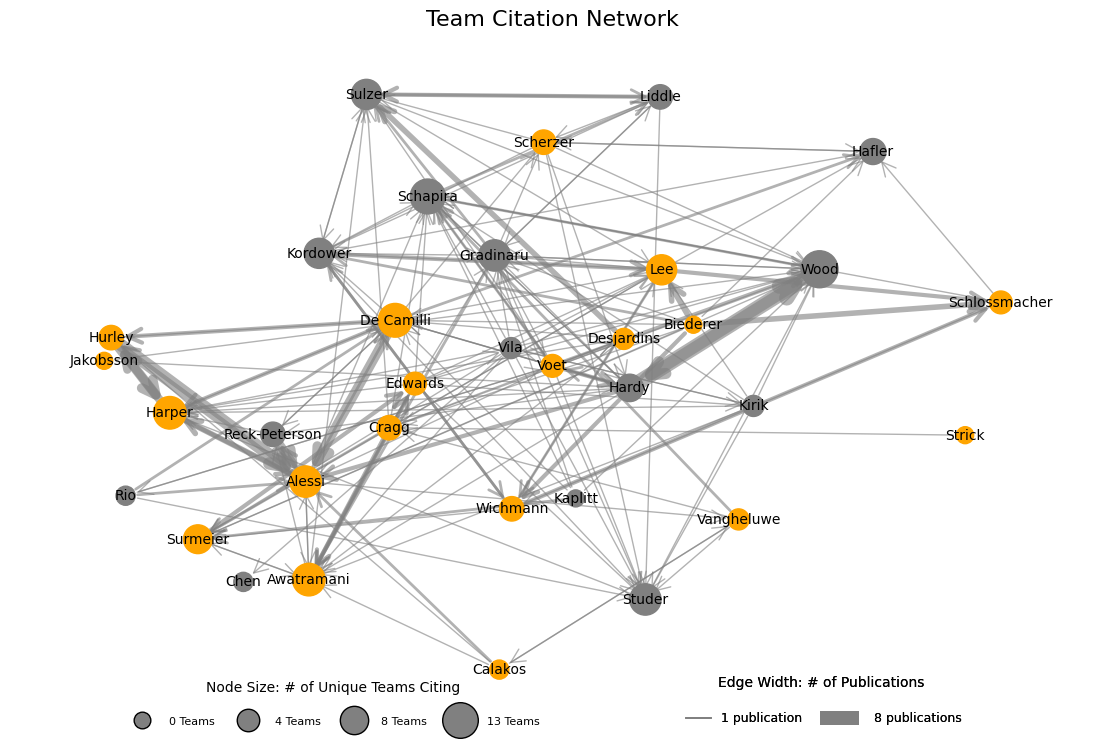

In [25]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import colorcet as cc


edges = defaultdict(int)
all_teams = set()



# Group by publication
for pub_id, group in citation_df.groupby('OpenAlex_ID'):
    source_teams = set()
    for teams in group['CleanedTeams']:
        source_teams.update([t for t in teams if pd.notna(t)])

    target_teams = set()
    for teams in group['ReferencedTeams']:
        target_teams.update([t for t in teams if pd.notna(t)])

    all_teams.update(source_teams)
    all_teams.update(target_teams)

    for source in source_teams:
        for target in target_teams:
            if source != target:  # no self-loops in base graph
                edges[(source, target)] += 1

# Add any extra teams found in Team column
# Step 4 (revised): Ensure all teams from the Team column are included
team_column_teams = set()

for team_list in citation_df['Team']:
    if isinstance(team_list, list):
        for team in team_list:
            if pd.notna(team):
                team_column_teams.add(team)

# Add missing teams to node list
all_teams.update(team_column_teams)



G_base = nx.DiGraph()
G_base.add_nodes_from(all_teams)

for (src, tgt), weight in edges.items():
    G_base.add_edge(src, tgt, weight=weight)

# Create layout with higher k for spread-out effect
pos = nx.spring_layout(G_base, seed=42, k=1.45)  # Adjust k for more spread

import numpy as np

# Compute center of existing layout (to push away from it)
center_x = np.mean([x for x, y in pos.values()])
center_y = np.mean([y for x, y in pos.values()])

# Apply offset to push manual nodes outward from the center
offset = .5  # adjust this to control how far away they appear




fig, ax = plt.subplots(figsize=(14, 12))
supplement_status = dict(zip(teams_df['Team'], teams_df['Supplement']))

# Define color by supplement status: orange for Yes, grey for No
node_colors = [
    "orange" if supplement_status.get(n.replace("Team ", ""), "No") == "Yes" else "grey"
    for n in G_base.nodes
]

# Compute node sizes based on the number of incoming edges (in-degree)
in_degrees = dict(G_base.in_degree())
print("Incoming degree for Schapira:", in_degrees.get('Schapira', 0))
# Scale node sizes for better visualization (e.g., base size 800, add 200 per incoming edge)
node_sizes = [150 + 40 * in_degrees.get(n, 0) for n in G_base.nodes]


nx.draw_networkx_nodes(G_base, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
nx.draw_networkx_edges(G_base, pos, width=[G_base[u][v]['weight'] for u, v in G_base.edges()], alpha=0.6, edge_color='gray', arrows=True, arrowstyle='->', arrowsize=25, ax=ax)
nx.draw_networkx_labels(G_base, pos, font_size=10, ax=ax)


min_collabs = 0
max_collabs = 13
mid1 = min_collabs + (max_collabs - min_collabs) // 3
mid2 = min_collabs + 2 * (max_collabs - min_collabs) // 3


# Map to node sizes using your existing size logic
def scale_node_size(n_collabs):
    return 4 + n_collabs * .5  # Match your sizing logic

legend_nodes = [
    (min_collabs, scale_node_size(min_collabs)),
    (mid1, scale_node_size(mid1)),
    (mid2, scale_node_size(mid2)),
    (max_collabs, scale_node_size(max_collabs)),
]

import matplotlib.patches as mpatches

# Define legend values and corresponding sizes (example logic)
legend_collabs = [min_collabs, mid1, mid2, max_collabs]
legend_sizes = [12 + (val * 1.05) for val in legend_collabs]

# Create circle patches for the legend
node_legend_handles = [
    plt.Line2D([], [], marker='o', linestyle='None',
               markersize=size,  # scale appropriately
               markerfacecolor='gray', markeredgecolor='black',
               label=f'  {val} Teams')
    for val, size in zip(legend_collabs, legend_sizes)
]

# Legend
legend1 = ax.legend(
    handles=node_legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.3, -0.009),  # Negative y moves it below the plot
    ncol=len(node_legend_handles),
    title='Node Size: # of Unique Teams Citing \n',
    fontsize=8,
    title_fontsize=10,
    frameon=False
)

ax.add_artist(legend1)

#=== Edge Width Legend ===
min_w = 1
max_w = 8
def scale_width(w): return .01 + (w / max_w) * 10
import matplotlib.lines as mlines
edge_legend_handles = [
    mlines.Line2D([], [], color='gray', linewidth=scale_width(min_w), label=f"{min_w} publication"),
    mlines.Line2D([], [], color='gray', linewidth=scale_width(max_w), label=f"   {max_w} publications")
]

legend2 = ax.legend(
    handles=edge_legend_handles,
    title="Edge Width: # of Publications \n",
    loc='lower center',
    bbox_to_anchor=(0.75, -0.009),
    ncol=2,
    fontsize=9,
    title_fontsize=10,
    frameon=False
)
ax.add_artist(legend2)

# Add this to expand the bottom margin for the legend
plt.subplots_adjust(bottom=0.3)



plt.title("Team Citation Network", fontsize=16)
plt.axis('off')
plt.savefig("og_research_with_self_ref_team_citation_network.pdf", dpi=300, bbox_inches='tight')
#nx.write_gexf(G_base, "with_self_ref_team_citation_network.gexf")

# Alternatively, save as GraphML
#nx.write_graphml(G_base, "with_self_ref_team_citation_network.graphml")
plt.show()


## Run the following block before running graph blocks to generate versions of graphs without self references

In [28]:
def has_self_reference(row):
    if not isinstance(row['CleanedTeams'], list) or not isinstance(row['ReferencedTeams'], list):
        return False
    cleaned = set(t for t in row['CleanedTeams'] if pd.notna(t))
    referenced = set(t for t in row['ReferencedTeams'] if pd.notna(t))
    return not cleaned.isdisjoint(referenced)  # True if any overlap

# Filter: keep only rows without self-reference
no_self_citation_df = citation_df[~citation_df.apply(has_self_reference, axis=1)].reset_index(drop=True)


Incoming degree for Schapira: 8


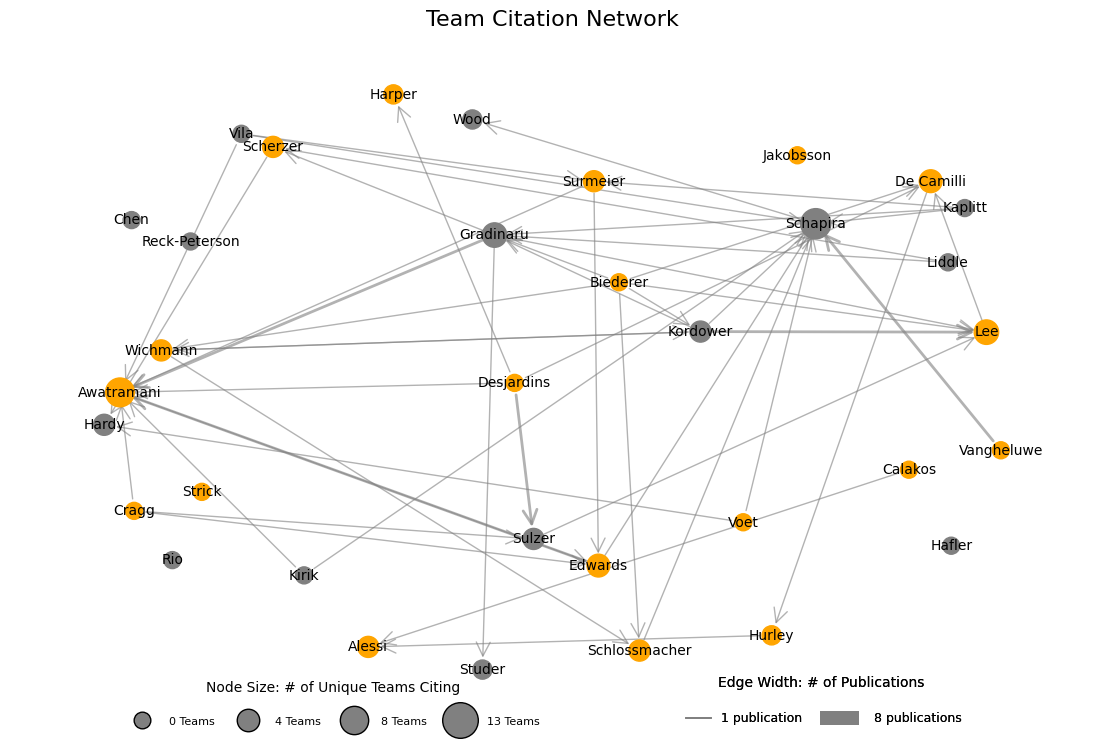

In [29]:
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
import colorcet as cc


edges = defaultdict(int)
all_teams = set()



# Group by publication
for pub_id, group in no_self_citation_df.groupby('OpenAlex_ID'):
    source_teams = set()
    for teams in group['CleanedTeams']:
        source_teams.update([t for t in teams if pd.notna(t)])

    target_teams = set()
    for teams in group['ReferencedTeams']:
        target_teams.update([t for t in teams if pd.notna(t)])

    all_teams.update(source_teams)
    all_teams.update(target_teams)

    for source in source_teams:
        for target in target_teams:
            if source != target:  # no self-loops in base graph
                edges[(source, target)] += 1

# Add any extra teams found in Team column
# Step 4 (revised): Ensure all teams from the Team column are included
team_column_teams = set()

for team_list in no_self_citation_df['Team']:
    if isinstance(team_list, list):
        for team in team_list:
            if pd.notna(team):
                team_column_teams.add(team)

# Add missing teams to node list
all_teams.update(team_column_teams)



G_base = nx.DiGraph()
G_base.add_nodes_from(all_teams)

for (src, tgt), weight in edges.items():
    G_base.add_edge(src, tgt, weight=weight)

# Create layout with higher k for spread-out effect
pos = nx.spring_layout(G_base, seed=42, k=1.45)  # Adjust k for more spread

import numpy as np

# Compute center of existing layout (to push away from it)
center_x = np.mean([x for x, y in pos.values()])
center_y = np.mean([y for x, y in pos.values()])

# Apply offset to push manual nodes outward from the center
offset = .5  # adjust this to control how far away they appear




fig, ax = plt.subplots(figsize=(14, 12))
supplement_status = dict(zip(teams_df['Team'], teams_df['Supplement']))

# Define color by supplement status: orange for Yes, grey for No
node_colors = [
    "orange" if supplement_status.get(n.replace("Team ", ""), "No") == "Yes" else "grey"
    for n in G_base.nodes
]

# Compute node sizes based on the number of incoming edges (in-degree)
in_degrees = dict(G_base.in_degree())
print("Incoming degree for Schapira:", in_degrees.get('Schapira', 0))
# Scale node sizes for better visualization (e.g., base size 800, add 200 per incoming edge)
node_sizes = [150 + 40 * in_degrees.get(n, 0) for n in G_base.nodes]


nx.draw_networkx_nodes(G_base, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
nx.draw_networkx_edges(G_base, pos, width=[G_base[u][v]['weight'] for u, v in G_base.edges()], alpha=0.6, edge_color='gray', arrows=True, arrowstyle='->', arrowsize=25, ax=ax)
nx.draw_networkx_labels(G_base, pos, font_size=10, ax=ax)


min_collabs = 0
max_collabs = 13
mid1 = min_collabs + (max_collabs - min_collabs) // 3
mid2 = min_collabs + 2 * (max_collabs - min_collabs) // 3


# Map to node sizes using your existing size logic
def scale_node_size(n_collabs):
    return 4 + n_collabs * .5  # Match your sizing logic

legend_nodes = [
    (min_collabs, scale_node_size(min_collabs)),
    (mid1, scale_node_size(mid1)),
    (mid2, scale_node_size(mid2)),
    (max_collabs, scale_node_size(max_collabs)),
]

import matplotlib.patches as mpatches

# Define legend values and corresponding sizes (example logic)
legend_collabs = [min_collabs, mid1, mid2, max_collabs]
legend_sizes = [12 + (val * 1.05) for val in legend_collabs]

# Create circle patches for the legend
node_legend_handles = [
    plt.Line2D([], [], marker='o', linestyle='None',
               markersize=size,  # scale appropriately
               markerfacecolor='gray', markeredgecolor='black',
               label=f'  {val} Teams')
    for val, size in zip(legend_collabs, legend_sizes)
]

# Legend
legend1 = ax.legend(
    handles=node_legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.3, -0.009),  # Negative y moves it below the plot
    ncol=len(node_legend_handles),
    title='Node Size: # of Unique Teams Citing \n',
    fontsize=8,
    title_fontsize=10,
    frameon=False
)

ax.add_artist(legend1)

#=== Edge Width Legend ===
min_w = 1
max_w = 8
def scale_width(w): return .01 + (w / max_w) * 10
import matplotlib.lines as mlines
edge_legend_handles = [
    mlines.Line2D([], [], color='gray', linewidth=scale_width(min_w), label=f"{min_w} publication"),
    mlines.Line2D([], [], color='gray', linewidth=scale_width(max_w), label=f"   {max_w} publications")
]

legend2 = ax.legend(
    handles=edge_legend_handles,
    title="Edge Width: # of Publications \n",
    loc='lower center',
    bbox_to_anchor=(0.75, -0.009),
    ncol=2,
    fontsize=9,
    title_fontsize=10,
    frameon=False
)
ax.add_artist(legend2)

# Add this to expand the bottom margin for the legend
plt.subplots_adjust(bottom=0.3)



plt.title("Team Citation Network", fontsize=16)
plt.axis('off')
plt.savefig("og_research_no_self_ref_team_citation_network.pdf", dpi=300, bbox_inches='tight')
#nx.write_gexf(G_base, "with_self_ref_team_citation_network.gexf")

# Alternatively, save as GraphML
#nx.write_graphml(G_base, "with_self_ref_team_citation_network.graphml")
plt.show()


## Citation in vs out degree scatterplot

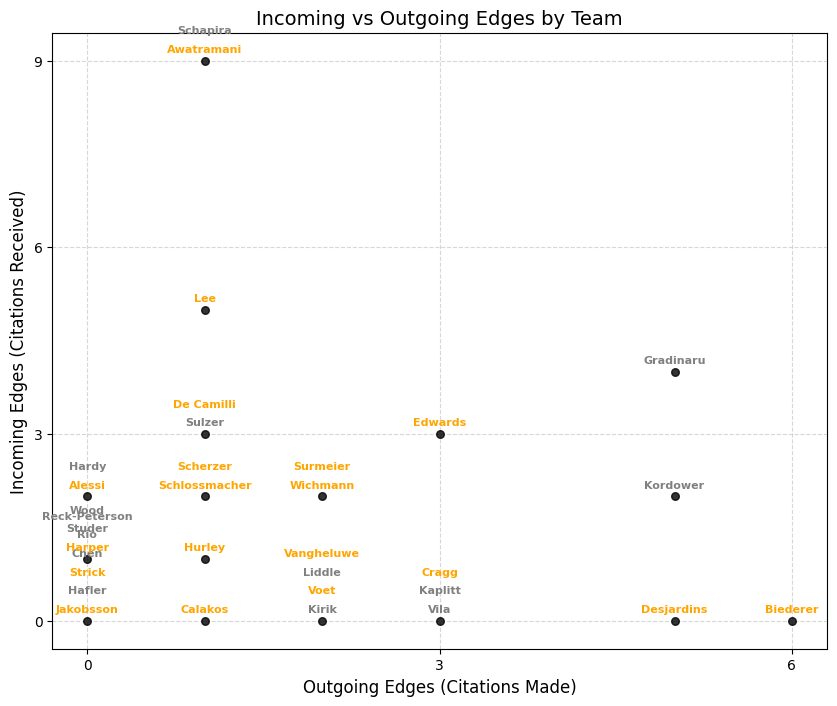

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import defaultdict

# Compute incoming and outgoing edge weights per team
incoming_weights = dict(G_base.in_degree(weight="weight"))
outgoing_weights = dict(G_base.out_degree(weight="weight"))

# Make a DataFrame
team_df = pd.DataFrame({
    "Team": list(G_base.nodes),
    "Incoming": [incoming_weights.get(t, 0) for t in G_base.nodes],
    "Outgoing": [outgoing_weights.get(t, 0) for t in G_base.nodes]
})

# Optionally add Supplement color
team_df["Supplement"] = team_df["Team"].map(lambda t: supplement_status.get(t.replace("Team ", ""), "No"))
team_df["Color"] = team_df["Supplement"].map({"Yes": "orange", "No": "grey"})

# Group teams by (Outgoing, Incoming) coordinates
coords = defaultdict(list)
for _, row in team_df.iterrows():
    coords[(row["Outgoing"], row["Incoming"])].append((row["Team"], row["Color"]))

# Scatterplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each unique coordinate once
for (x, y), teams in coords.items():
    # Draw the scatter point
    ax.scatter(x, y, c="black", s=30, alpha=0.8, edgecolor="black", zorder=2)
    
    # Stack labels vertically above the point
    for i, (team, color) in enumerate(teams):
        ax.text(
            x, y + 0.1 + i*0.3, team,
            ha="center", va="bottom", fontsize=8, fontweight="bold", color=color
        )

# Labels and ticks
ax.set_xlabel("Outgoing Edges (Citations Made)", fontsize=12)
ax.set_ylabel("Incoming Edges (Citations Received)", fontsize=12)
ax.set_title("Incoming vs Outgoing Edges by Team", fontsize=14)

# Use multiples of 3 for ticks
ax.xaxis.set_major_locator(mticker.MultipleLocator(3))
ax.yaxis.set_major_locator(mticker.MultipleLocator(3))

plt.grid(True, linestyle="--", alpha=0.5)
plt.savefig("og_research_no_self_ref_incoming_vs_outgoing_edges_by_team.pdf", dpi=300)
plt.show()


In [13]:
total_outgoing = team_df["Outgoing"].sum()
total_incoming = team_df["Incoming"].sum()

print("Total Outgoing (sum of all x values):", total_outgoing)
print("Total Incoming (sum of all y values):", total_incoming)


Total Outgoing (sum of all x values): 54
Total Incoming (sum of all y values): 54


In [27]:
from scipy import stats
import numpy as np

# Statistical comparison of incoming edge counts by Supplement status
# Uses existing `team_df` if present, otherwise constructs from `G_base` and `supplement_status`.


# Prepare dataframe of teams -> incoming & supplement
if 'team_df' in globals():
    df = team_df.copy()
else:
    # fallback: build team_df from G_base and supplement_status
    incoming_weights = dict(G_base.in_degree(weight="weight"))
    df = pd.DataFrame({
        "Team": list(G_base.nodes),
        "Incoming": [incoming_weights.get(t, 0) for t in G_base.nodes]
    })
    df["Supplement"] = df["Team"].map(lambda t: supplement_status.get(t, "No"))

# Ensure Supplement values are strings and filter valid groups
df['Supplement'] = df['Supplement'].fillna('No').astype(str)
yes_vals = df.loc[df['Supplement'].str.lower() == 'yes', 'Incoming'].dropna().astype(float)
no_vals  = df.loc[df['Supplement'].str.lower() == 'no',  'Incoming'].dropna().astype(float)

# Basic checks
n_yes = len(yes_vals)
n_no  = len(no_vals)

print(f"Group sizes -> Yes: {n_yes}, No: {n_no}")
print(f"Mean Incoming (Yes): {yes_vals.mean():.3f} | Median: {yes_vals.median():.3f}")
print(f"Mean Incoming (No) : {no_vals.mean():.3f} | Median: {no_vals.median():.3f}")
print("")

# Mann-Whitney U test (non-parametric)
# Use two-sided test
if n_yes > 0 and n_no > 0:
    u_stat, mw_p = stats.mannwhitneyu(yes_vals, no_vals, alternative='two-sided')
    print(f"Mann-Whitney U: U={u_stat:.3f}, p-value={mw_p:.4g}")
else:
    print("Mann-Whitney U: not enough data in one of the groups.")

# Welch's t-test (independent t-test, unequal variances)
if n_yes > 1 and n_no > 1:
    t_stat, t_p = stats.ttest_ind(yes_vals, no_vals, equal_var=False, nan_policy='omit')
    print(f"Welch's t-test: t={t_stat:.3f}, p-value={t_p:.4g}")
else:
    print("Welch's t-test: not enough data (need >=2 per group).")

Group sizes -> Yes: 19, No: 15
Mean Incoming (Yes): 8.368 | Median: 7.000
Mean Incoming (No) : 8.133 | Median: 6.000

Mann-Whitney U: U=136.000, p-value=0.8346
Welch's t-test: t=0.087, p-value=0.9315


## Hit Citation Analysis

In [14]:
combined_citation_df = pd.read_csv("network_hit_citation_table.csv")

In [19]:

 #Step 2: Merge on OpenAlex_ID
hit_df = citation_df.merge(
    combined_citation_df[['OpenAlex_ID', 'SubFieldIdC5Rank', 'SubFieldId']],
    on=['OpenAlex_ID'],
    how='left'  # 'left' ensures all rows in df are retained
)


In [20]:
hit_df.drop_duplicates(subset=['OpenAlex_ID', 'SubFieldId', 'SubFieldIdC5Rank'], keep='first', inplace=True)

Add column for date created (already created in network_hit_citation_table.csv)

In [31]:


import numpy as np
import time

# Add 'DateCreated' column if it doesn't exist
if 'DateCreated' not in hit_df.columns:
    hit_df['DateCreated'] = np.nan

def is_empty(val):
    if val is None:
        return True
    # If it's a list, tuple, or set, check length
    if isinstance(val, (list, tuple, set)):
        return len(val) == 0
    # If it's a numpy array or pandas Series, check length
    if hasattr(val, "__len__") and not isinstance(val, str):
        try:
            return len(val) == 0
        except Exception:
            pass
    # If it's a string like '[]', 'nan', etc.
    if isinstance(val, str):
        val = val.strip()
        return val in ('', '[]', 'nan')
    # For scalars, use pd.isna
    try:
        return pd.isna(val)
    except Exception:
        return False

filled_count = 0

for idx, row in hit_df.iterrows():
    openalex_id = str(row['OpenAlex_ID']).strip()
    if openalex_id.startswith("W") and is_empty(row['DateCreated']):
        try:
            work = Works()[openalex_id]
            if work and 'created_date' in work:
                hit_df.at[idx, 'DateCreated'] = work['created_date']
                filled_count += 1
        except Exception as e:
            print(f"❌ Failed for {openalex_id}: {e}")
        time.sleep(0.25)  # avoid rate limiting

print(f"✅ Filled DateCreated for {filled_count} rows.")


❌ Failed for W4226263121: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4226263121
❌ Failed for W4226263121: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4226263121
❌ Failed for W4226263121: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4226263121
❌ Failed for W4220677882: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4220677882
❌ Failed for W4220677882: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4220677882
❌ Failed for W4220677882: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4220677882


KeyboardInterrupt: 

Add column for publication date (already created in network_hit_citation_table.csv)

In [32]:


import numpy as np
import time

# Add 'PublicationDate' column if it doesn't exist
if 'PublicationDate' not in hit_df.columns:
    hit_df['PublicationDate'] = np.nan

def is_empty(val):
    if val is None:
        return True
    # If it's a list, tuple, or set, check length
    if isinstance(val, (list, tuple, set)):
        return len(val) == 0
    # If it's a numpy array or pandas Series, check length
    if hasattr(val, "__len__") and not isinstance(val, str):
        try:
            return len(val) == 0
        except Exception:
            pass
    # If it's a string like '[]', 'nan', etc.
    if isinstance(val, str):
        val = val.strip()
        return val in ('', '[]', 'nan')
    # For scalars, use pd.isna
    try:
        return pd.isna(val)
    except Exception:
        return False

filled_count = 0

for idx, row in hit_df.iterrows():
    openalex_id = str(row['OpenAlex_ID']).strip()
    if openalex_id.startswith("W") and is_empty(row['PublicationDate']):
        try:
            work = Works()[openalex_id]
            if work and 'publication_date' in work:
                hit_df.at[idx, 'PublicationDate'] = work['publication_date']
                filled_count += 1
        except Exception as e:
            print(f"❌ Failed for {openalex_id}: {e}")
        time.sleep(0.25)  # avoid rate limiting

print(f"✅ Filled PublicationDate for {filled_count} rows.")


C:\Users\school\AppData\Local\Temp\ipykernel_22836\2449021958.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-02-07' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  hit_df.at[idx, 'PublicationDate'] = work['publication_date']


❌ Failed for W4226263121: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4226263121
❌ Failed for W4226263121: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4226263121
❌ Failed for W4226263121: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4226263121
❌ Failed for W4220677882: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4220677882
❌ Failed for W4220677882: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4220677882
❌ Failed for W4220677882: 404 Client Error: Not Found for url: https://api.openalex.org/works/W4220677882
✅ Filled PublicationDate for 970 rows.


Data type conversions


In [33]:
list_cols_to_str = ['ReferencedTeams', 'CleanedTeams']

for col in list_cols_to_str:
    if col in hit_df.columns:
        hit_df[col] = hit_df[col].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)

In [34]:
hit_df['PublicationDate'] = pd.to_datetime(hit_df['PublicationDate'], errors='coerce')
hit_df_date = hit_df[hit_df['PublicationDate'] < '2025-01-01']

In [35]:
hit_df[['OpenAlex_ID', 'DateCreated']]

,OpenAlex_ID,DateCreated
0,W4391629214,2025-10-10T00:00:00
1,W4391629214,2025-10-10T00:00:00
2,W4391629214,2025-10-10T00:00:00
21,W4390345401,2025-10-10T00:00:00
39,W4391450102,2025-10-10T00:00:00
...,...,...
12181,W4410027322,NaN
12199,W4410474885,NaN
12210,W4410607995,NaN
12229,W4410607677,NaN


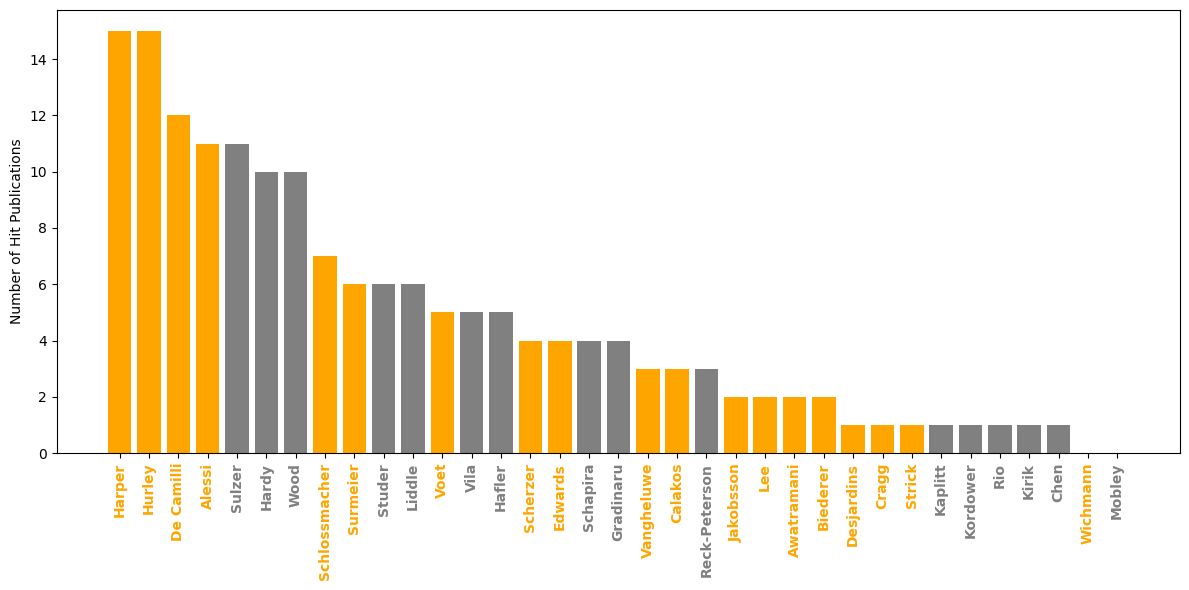

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter by DateCreated (before August 1, 2023)
#hit_df_date['DateCreated'] = pd.to_datetime(hit_df_date['DateCreated'], errors='coerce')
#hit_df_date = hit_df_date[hit_df_date['DateCreated'] < '2023-08-01']

# Step 2: Filter to only rows with score > 0.9
hit_df_filtered = hit_df_date[hit_df_date['SubFieldIdC5Rank'] > 0.9].copy()

# Step 3: Explode CleanedTeams
hit_df_filtered = hit_df_filtered.explode('CleanedTeams')

# Step 4: Clean team names (remove "Team " prefix)
hit_df_filtered['Team'] = hit_df_filtered['CleanedTeams'].str.replace("Team ", "", regex=False)

# Step 5: Drop duplicates on (OpenAlex_ID, Team)
hit_df_filtered = hit_df_filtered[['OpenAlex_ID', 'Team']].drop_duplicates()

# Step 6: Count unique publications per team
team_pub_counts = hit_df_filtered.groupby('Team')['OpenAlex_ID'].nunique().reset_index()
team_pub_counts.rename(columns={'OpenAlex_ID': 'NumPubsOver0.9'}, inplace=True)

supplement_df = pd.read_excel('Supplement Grants by Team.xlsx')
# Step 6.5: Clean Team names in supplement_df
supplement_df['Team'] = supplement_df['Team'].str.replace("Team ", "", regex=False)

# Step 6.6: Merge with supplement_df (ensure all supplement teams appear)
merged = pd.merge(supplement_df, team_pub_counts, on='Team', how='left')
merged['NumPubsOver0.9'] = merged['NumPubsOver0.9'].fillna(0).astype(int)
merged['Supplement'] = merged['Supplement'].fillna('No')

# Step 7: Sort
merged['SupplementBool'] = merged['Supplement'].map({'Yes': 1, 'No': 0})
merged = merged.sort_values(by=['NumPubsOver0.9', 'SupplementBool'], ascending=[False, False])

# Step 8: Plot
colors = ['orange' if val == 'Yes' else 'grey' for val in merged['Supplement']]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(merged['Team'], merged['NumPubsOver0.9'], color=colors)

# Set x-tick label colors
ax.set_xticks(range(len(merged)))
ax.set_xticklabels(merged['Team'], rotation=90, fontweight='bold')
for label, supp in zip(ax.get_xticklabels(), merged['Supplement']):
    label.set_color('orange' if supp == 'Yes' else 'grey')

#ax.set_title('Unique Publications with C5SubFieldIdRank > 0.9 (Before July 2023)')
ax.set_ylabel('Number of Hit Publications')
plt.tight_layout()
plt.savefig('unique_publications_gt_09_by_team_before_july_2023.pdf', dpi=300)
plt.show()


In [44]:
hit_df_date2['OpenAlex_ID'].nunique()

426

In [43]:
hit_df_date2 = hit_df[hit_df['PublicationDate'] < '2025-11-01']

In [41]:
from scipy.stats import ttest_ind, mannwhitneyu

# Split into groups
supp_yes = merged[merged['Supplement'] == 'Yes']['NumPubsOver0.9']
supp_no = merged[merged['Supplement'] == 'No']['NumPubsOver0.9']

# Run T-test
t_stat, t_pval = ttest_ind(supp_yes, supp_no, equal_var=False)

# Run Mann-Whitney U test
u_stat, u_pval = mannwhitneyu(supp_yes, supp_no, alternative='two-sided')

# Print results
print("T-test:")
print(supp_yes.mean(), supp_no.mean())
print(f"  t = {t_stat:.4f}, p = {t_pval:.4f}")

print("\nMann–Whitney U test:")
print(f"  U = {u_stat:.4f}, p = {u_pval:.4f}")


T-test:
5.052631578947368 4.3125
  t = 0.5242, p = 0.6037

Mann–Whitney U test:
  U = 162.5000, p = 0.7384


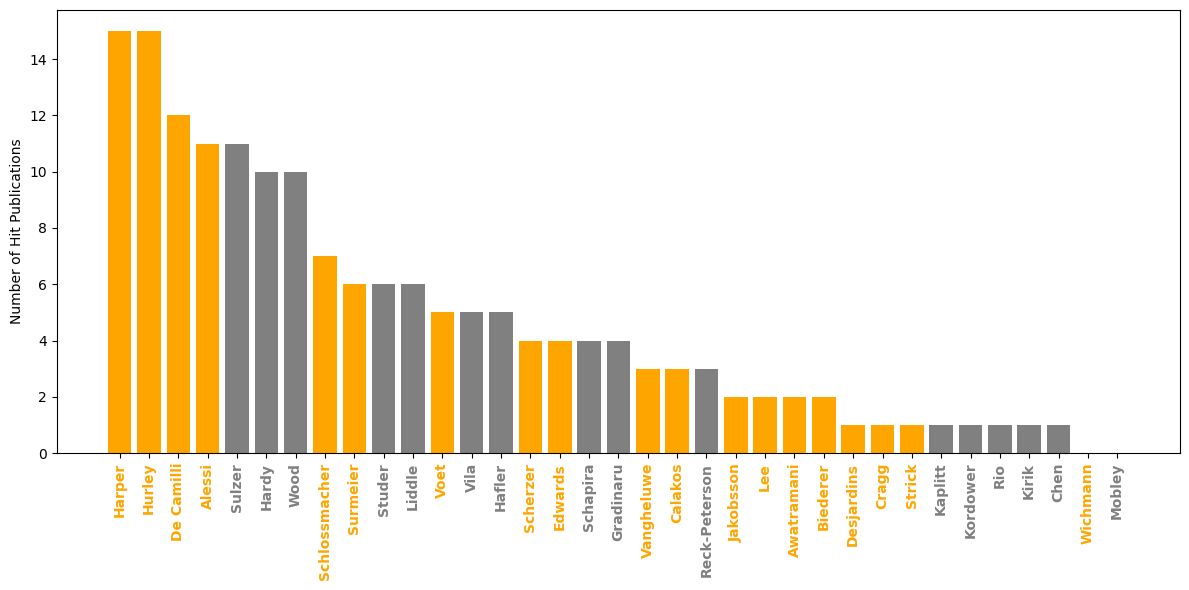

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter by DateCreated (before August 1, 2023)
#hit_df_date['DateCreated'] = pd.to_datetime(hit_df_date['DateCreated'], errors='coerce')
#hit_df_date = hit_df_date[hit_df_date['DateCreated'] < '2023-08-01']

# Step 2: Filter to only rows with score > 0.9
hit_df_filtered = hit_df_date[hit_df_date['SubFieldIdC5Rank'] > 0.9].copy()

# Step 3: Explode CleanedTeams
hit_df_filtered = hit_df_filtered.explode('CleanedTeams')

# Step 4: Clean team names (remove "Team " prefix)
hit_df_filtered['Team'] = hit_df_filtered['CleanedTeams'].str.replace("Team ", "", regex=False)

# Step 5: Drop duplicates on (OpenAlex_ID, Team)
hit_df_filtered = hit_df_filtered[['OpenAlex_ID', 'Team']].drop_duplicates()

# Step 6: Count unique publications per team
team_pub_counts = hit_df_filtered.groupby('Team')['OpenAlex_ID'].nunique().reset_index()
team_pub_counts.rename(columns={'OpenAlex_ID': 'NumPubsOver0.9'}, inplace=True)

supplement_df = pd.read_excel('Supplement Grants by Team.xlsx')
# Step 6.5: Clean Team names in supplement_df
supplement_df['Team'] = supplement_df['Team'].str.replace("Team ", "", regex=False)

# Step 6.6: Merge with supplement_df (ensure all supplement teams appear)
merged = pd.merge(supplement_df, team_pub_counts, on='Team', how='left')
merged['NumPubsOver0.9'] = merged['NumPubsOver0.9'].fillna(0).astype(int)
merged['Supplement'] = merged['Supplement'].fillna('No')

# Step 7: Sort
merged['SupplementBool'] = merged['Supplement'].map({'Yes': 1, 'No': 0})
merged = merged.sort_values(by=['NumPubsOver0.9', 'SupplementBool'], ascending=[False, False])

# Step 8: Plot
colors = ['orange' if val == 'Yes' else 'grey' for val in merged['Supplement']]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(merged['Team'], merged['NumPubsOver0.9'], color=colors)

# Set x-tick label colors
ax.set_xticks(range(len(merged)))
ax.set_xticklabels(merged['Team'], rotation=90, fontweight='bold')
for label, supp in zip(ax.get_xticklabels(), merged['Supplement']):
    label.set_color('orange' if supp == 'Yes' else 'grey')

#ax.set_title('Unique Publications with C5SubFieldIdRank > 0.9 (Before July 2023)')
ax.set_ylabel('Number of Hit Publications')
plt.tight_layout()
plt.savefig('unique_publications_gt_09_by_team_before_july_2023.pdf', dpi=300)
plt.show()


In [38]:
research_df.columns

NameError: name 'research_df' is not defined

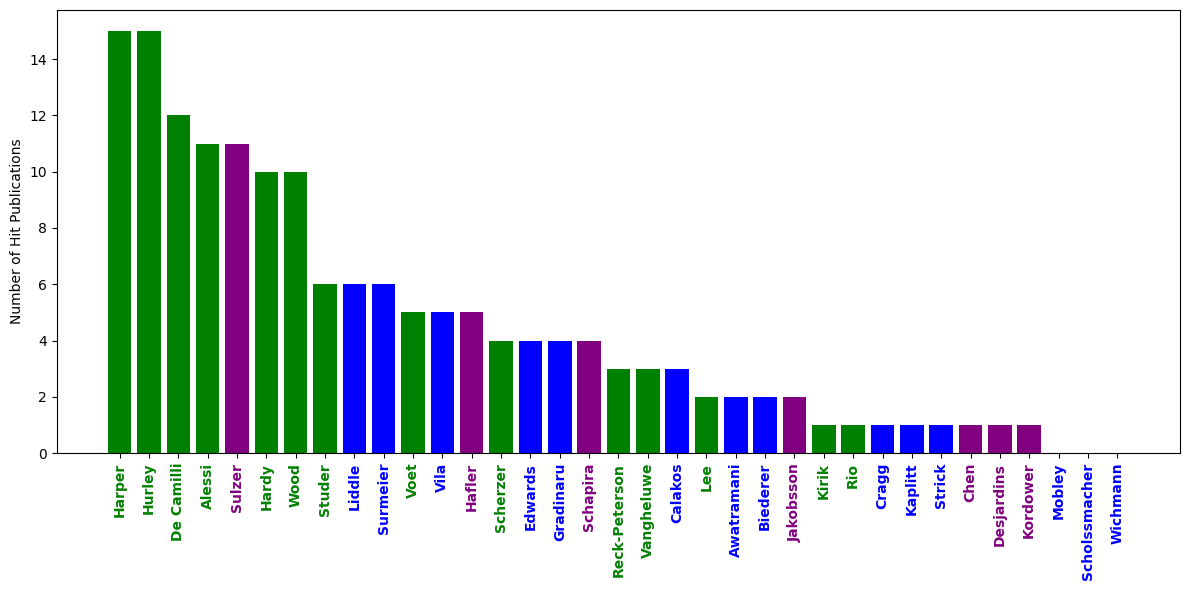

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter by DateCreated (before August 1, 2023)
#hit_df_date['DateCreated'] = pd.to_datetime(hit_df_date['DateCreated'], errors='coerce')
#hit_df_date = hit_df_date[hit_df_date['DateCreated'] < '2023-08-01']

# Step 2: Filter to only rows with score > 0.9
hit_df_filtered = hit_df_date[hit_df_date['SubFieldIdC5Rank'] > 0.9].copy()

# Step 3: Explode CleanedTeams
hit_df_filtered = hit_df_filtered.explode('CleanedTeams')

# Step 4: Clean team names (remove "Team " prefix)
hit_df_filtered['Team'] = hit_df_filtered['CleanedTeams'].str.replace("Team ", "", regex=False)

# Step 5: Drop duplicates on (OpenAlex_ID, Team)
hit_df_filtered = hit_df_filtered[['OpenAlex_ID', 'Team']].drop_duplicates()

# Step 6: Count unique publications per team
team_pub_counts = hit_df_filtered.groupby('Team')['OpenAlex_ID'].nunique().reset_index()
team_pub_counts.rename(columns={'OpenAlex_ID': 'NumPubsOver0.9'}, inplace=True)

research_df = pd.read_csv('CRN Team x Research Theme - Sheet1.csv')
# Step 6.5: Clean Team names in research_df
research_df['Team'] = research_df['team'].str.replace("Team ", "", regex=False)

# Step 6.6: Merge with research_df (ensure all supplement teams appear)
merged = pd.merge(research_df, team_pub_counts, on='Team', how='left')
merged['NumPubsOver0.9'] = merged['NumPubsOver0.9'].fillna(0).astype(int)
merged['research_theme'] = merged['research_theme'].fillna('No')

# Step 7: Sort
#{"PD Functional Genomics": "green", "Circuitry and Brain-Body Interactions": "blue", "Neuro-Immune Interactions":"purple"}
merged['Research_Sort'] = merged['research_theme'].map({'PD Functional Genomics': 2, 'Circuitry and Brain-Body Interactions': 1, 'Neuro-Immune Interactions': 0})
merged = merged.sort_values(by=['NumPubsOver0.9', 'Research_Sort'], ascending=[False, False])

# Step 8: Plot
colors = ['green' if val == 'PD Functional Genomics' else 'blue' if val == 'Circuitry and Brain-Body Interactions' else 'purple' for val in merged['research_theme']]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(merged['Team'], merged['NumPubsOver0.9'], color=colors)

# Set x-tick label colors
ax.set_xticks(range(len(merged)))
ax.set_xticklabels(merged['Team'], rotation=90, fontweight='bold')
for label, supp in zip(ax.get_xticklabels(), merged['research_theme']):
    label.set_color('green' if supp == 'PD Functional Genomics' else 'blue' if supp == 'Circuitry and Brain-Body Interactions' else 'purple')

#ax.set_title('Unique Publications with C5SubFieldIdRank > 0.9 (Before July 2023)')
ax.set_ylabel('Number of Hit Publications')
plt.tight_layout()
plt.savefig('rt_unique_publications_gt_09_by_team_before_july_2023.pdf', dpi=300)
plt.show()


# add test results(even fo little to no significance)

In [45]:
hit_df.to_csv("hit_citation_with_dates.csv", index=False)